In [1]:
import numpy as np
import os
import json
from glob import glob
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import utils.workspace as ws
from models.generator.generator import Generator


In [ ]:
# path_img = "../2dDeepSDF/data/test/test_images"
filenames_img = sorted(glob(os.path.join(path_img, "*.jpg")))
imgs = [plt.imread(f) for f in filenames_img]

# I/O paths
env_data_folder = "../2dDeepSDF/chomp256/Reconstructions/test/codes"
filenames_env = sorted(glob(os.path.join(env_data_folder, '*.npy')))
envs = [np.load(f) for f in filenames_env ]

print("Found {} images".format(len(filenames_img)))
print("Found {} Latent codes".format(len(filenames_env)))

In [3]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

experiment_directory = "models"
checkpoint = str(500)
specs = ws.load_experiment_specifications(experiment_directory)


# Instantiating the generator
specs_g = specs["generator"]
input_dim = specs_g["InputDim"]
n_points = specs_g["NPoints"]
generator = Generator(input_dim, n_points).to(device)

path_to_model_dir = os.path.join(experiment_directory,"generator", ws.model_params_dir)
print("Loading checkpoint {} model from: {}".format(
    checkpoint, os.path.abspath(path_to_model_dir)))
generator.load_model_parameters(path_to_model_dir, checkpoint)

print('############# Generator Model: #####################')
print(generator)
print('######################################################')
generator.to(device)
generator.eval()

Using GPU
Loading checkpoint 500 model from: /home/user/Documents/Alassane/motionPlanning/2d/2d_trajectory_generator/cgan_wtl/models/generator/ModelParameters
############# Generator Model: #####################
Generator(
  (model): Sequential(
    (0): Linear(in_features=260, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=

Generator(
  (model): Sequential(
    (0): Linear(in_features=260, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=512, out_features=124, bias=True)
    (12): Sigmoid()
  )
)

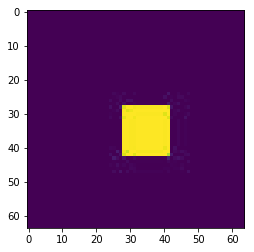

In [4]:
plt.imshow(imgs[0])

In [7]:
def generate(start, goal, img_nb, envs=envs, imgs=imgs):
    start = np.array(start) / 63
    goal = np.array(goal) / 63
    img = imgs[img_nb]
    env = np.squeeze(envs[img_nb])
    
    inputs = np.concatenate([env,start, goal], axis=0)

    inputs = torch.from_numpy(inputs).unsqueeze(0).to(device).float()
    with torch.no_grad():
        trajectory_intermediate = generator(inputs).squeeze().cpu().numpy()
    trajectory = np.concatenate([start, trajectory_intermediate, goal], axis=0).reshape(-1,2) *64
    
    # Plotting the treajectory
    x = trajectory[:,0]
    y = trajectory[:,1]
    
#     fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(6,3))

    plt.plot(x, y, "o")
    plt.gca().invert_yaxis()
    plt.imshow(img)
#     plt.show()
    plt.title("Generated trajectory")
    plt.draw()


In [12]:
%matplotlib qt
start, goal = [30,40], [50, 10]
img_nb = 7
generate(start, goal, img_nb)